<a href="https://colab.research.google.com/github/Changho0514/web1/blob/main/220117_Object_Detection_yolov5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
!git clone https://github.com/ultralytics/yolov5  # clone
!pip install -qr yolov5/requirements.txt  # install

fatal: destination path 'yolov5' already exists and is not an empty directory.


In [17]:
import pandas as pd
import numpy as np
import os
import glob
from datetime import datetime
import xml.etree.ElementTree as ET 
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm import tqdm
warnings.filterwarnings('ignore')

# Annotation Read and Handling

- https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/

In [18]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!unzip "/content/drive/MyDrive/data (1)/archive.zip" ### todo: change the path

Archive:  /content/drive/MyDrive/data (1)/archive.zip
replace annotations/maksssksksss0.xml? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace annotations/maksssksksss1.xml? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace annotations/maksssksksss10.xml? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [19]:
path_an = "/content/annotations" ### todo: change the path

In [20]:
dataset = {
            "file":[],
            "name":[],    
            "width":[],
            "height":[],
            "xmin":[],
            "ymin":[],   
            "xmax":[],
            "ymax":[],
           }

for anno in tqdm(glob.glob(path_an+"/*.xml")):
    tree = ET.parse(anno)
    
    for elem in tree.iter():
        if 'size' in elem.tag:
            for attr in list(elem):
                if 'width' in attr.tag: 
                    width = int(round(float(attr.text)))
                if 'height' in attr.tag:
                    height = int(round(float(attr.text)))    

        if 'object' in elem.tag:
            for attr in list(elem):
                
                if 'name' in attr.tag:
                    name = attr.text                 
                    dataset['name'].append(name)
                    dataset['width'].append(width)
                    dataset['height'].append(height) 
                    dataset['file'].append(anno.split('/')[-1][0:-4])

                # Scaling 작업.            
                if 'bndbox' in attr.tag:
                    for dim in list(attr):
                        if 'xmin' in dim.tag: # xmin, ymin은 좌측 상단, xmax, ymax는 우측하단
                            xmin = int(round(float(dim.text)))
                            dataset['xmin'].append(xmin)
                        if 'ymin' in dim.tag:
                            ymin = int(round(float(dim.text)))
                            dataset['ymin'].append(ymin)                                
                        if 'xmax' in dim.tag:
                            xmax = int(round(float(dim.text)))
                            dataset['xmax'].append(xmax)                                
                        if 'ymax' in dim.tag:
                            ymax = int(round(float(dim.text)))
                            dataset['ymax'].append(ymax) 

    #break

100%|██████████| 853/853 [00:00<00:00, 5865.38it/s]


In [7]:
# dataset

In [21]:
df=pd.DataFrame(dataset)

name_dict = {
    'with_mask': 0,
    'mask_weared_incorrect': 1,
    'without_mask': 2 
}

df['class'] = df['name'].map(name_dict)

df.head()

,file,name,width,height,xmin,ymin,xmax,ymax,class
0,maksssksksss559,with_mask,400,256,7,215,50,256,0
1,maksssksksss559,with_mask,400,256,64,190,92,219,0
2,maksssksksss559,with_mask,400,256,96,161,148,220,0
3,maksssksksss559,with_mask,400,256,183,137,214,179,0
4,maksssksksss559,with_mask,400,256,120,53,138,72,0


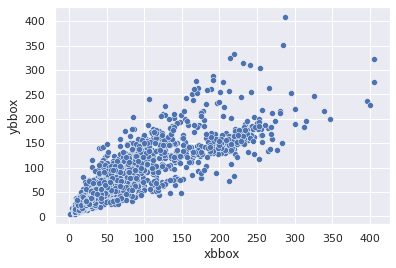

In [22]:
H, W = 640, 480

# Yolo 돌리기 위한 작업. x_center, y_center, axis, height가 scaling 되어있어야하니까.
df['xmax'] = (H/df['width'])*df['xmax'] # Rescale 작업.
df['ymax'] = (W/df['height'])*df['ymax']
df['xmin'] = (H/df['width'])*df['xmin']
df['ymin'] = (W/df['height'])*df['ymin']

df[['xmax', 'ymax', 'xmin', 'ymin']] = df[['xmax', 'ymax', 'xmin', 'ymin']].astype('int64') # integer로 바꿔주는 이유는 bounding box 좌표가 소수점이면 plot(그리기)할때 index가 float이면 에러발생.
df['x_center'] = (df['xmax']+df['xmin'])/(2*H) # 0~1 값으로 바꾸기 위해 2*H로 나눠줌.
df['y_center'] = (df['ymax']+df['ymin'])/(2*W)
df['box_height'] = (df['xmax']-df['xmin'])/H
df['box_width'] = (df['ymax']-df['ymin'])/W

df['xbbox'] = df['xmax']-df['xmin']
df['ybbox'] = df['ymax']-df['ymin']

sns.set()
sns.scatterplot(x='xbbox',  y='ybbox', data=df)
plt.show()

In [23]:
df.info() # null값 없어야 잘 돌아가니까

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4072 entries, 0 to 4071
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   file        4072 non-null   object 
 1   name        4072 non-null   object 
 2   width       4072 non-null   int64  
 3   height      4072 non-null   int64  
 4   xmin        4072 non-null   int64  
 5   ymin        4072 non-null   int64  
 6   xmax        4072 non-null   int64  
 7   ymax        4072 non-null   int64  
 8   class       4072 non-null   int64  
 9   x_center    4072 non-null   float64
 10  y_center    4072 non-null   float64
 11  box_height  4072 non-null   float64
 12  box_width   4072 non-null   float64
 13  xbbox       4072 non-null   int64  
 14  ybbox       4072 non-null   int64  
dtypes: float64(4), int64(9), object(2)
memory usage: 477.3+ KB


# Split Data into Train, Validation, and Test.

In [24]:
image_dir = '/content/images'
fileNames = [*os.listdir(image_dir)] # image directory 기준으로 나누기
len(fileNames)

853

In [25]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(fileNames, test_size=0.1, random_state=22)
test, val = train_test_split(test, test_size=0.7, random_state=22)
print("Length of Train =",len(train))
print("="*30)
print("Length of Valid =",len(val))
print("="*30)
print("Length of test =", len(test))

Length of Train = 767
Length of Valid = 61
Length of test = 25


In [13]:
os.makedirs('./yolov5/data/train/images', exist_ok = True)
os.makedirs('./yolov5/data/train/labels', exist_ok = True)
os.makedirs('./yolov5/data/test/images', exist_ok = True)
os.makedirs('./yolov5/data/test/labels', exist_ok = True)
os.makedirs('./yolov5/data/val/images', exist_ok = True)
os.makedirs('./yolov5/data/val/labels', exist_ok = True)

In [14]:
from PIL import Image

def copyImages(imageList, folder_Name, height=640, width=480, from_dir='/content/images', to_dir='./yolov5/data/'):
    for image in tqdm(imageList):
        img = Image.open(os.path.join(from_dir,image)) # from_dir에서 파일명 불러오고 image에 입력
        img1 = img.resize((height, width)) # rescaling
        _ = img1.save(os.path.join(to_dir,folder_Name,"images",image))

In [26]:
copyImages(train, "train") #### todo: set the from_dir parameter
copyImages(val, "val")  #### todo: set the from_dir parameter
copyImages(test, "test") #### todo: set the from_dir parameter

100%|██████████| 25/25 [00:04<00:00,  6.00it/s]


In [27]:
df = df.astype('string')

In [28]:
def create_labels(image_list, data_name, data_root = "./yolov5/data/"):
    fileNames = [x.split(".")[0] for x in image_list]

    for name in tqdm(fileNames):
        data = df[df.file==name]
        box_list = []
        
        for index in range(len(data)):
            row = data.iloc[index]
            box_list.append(row['class']+" "+row["x_center"]+" "+row["y_center"]\
                        +" "+row["box_height"]+" "+row["box_width"])
            
        text = "\n".join(box_list)
        with open(os.path.join(data_root,data_name,"labels",name+".txt"), "w") as file:
            file.write(text)

In [29]:
create_labels(train, "train")
create_labels(val, "val")
create_labels(test, "test")

100%|██████████| 25/25 [00:00<00:00, 285.31it/s]


# Configuration Model

파일에 들어가기


In [30]:
%cd /content/yolov5

/content/yolov5


In [31]:
#train 하기
from IPython.core.display import Image, Video, clear_output  # to display images
import torch
from yolov5 import utils
display = utils.notebook_init()

YOLOv5 🚀 v6.0-192-g436ffc4 torch 1.10.0+cu111 CUDA:0 (Tesla K80, 11441MiB)


Setup complete ✅ (2 CPUs, 12.7 GB RAM, 43.5/78.2 GB disk)


In [32]:
yaml_text = """train: data/train/images
val: data/train/images

nc: 3
names: ['with_mask', 'mask_weared_incorrect', 'without_mask']"""

In [33]:
with open("data/data.yaml", 'w') as file:
    file.write(yaml_text)

In [34]:
%cat data/data.yaml


train: data/train/images
val: data/train/images

nc: 3
names: ['with_mask', 'mask_weared_incorrect', 'without_mask']

In [35]:
#customize iPython writefile so we can write variables
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [36]:
%%writetemplate models/custom_yolov5s.yaml

# parameters
nc: 3  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
    - [10,13, 16,30, 33,23]  # P3/8
    - [30,61, 62,45, 59,119]  # P4/16
    - [116,90, 156,198, 373,326]  # P5/32   # anchor 수정은 object detection에서 수정하여 성능향상을 기대할 수 있는 부분.

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, BottleneckCSP, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, BottleneckCSP, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, BottleneckCSP, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, BottleneckCSP, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
    [[-1, 1, Conv, [512, 1, 1]],
    [-1, 1, nn.Upsample, [None, 2, 'nearest']],
    [[-1, 6], 1, Concat, [1]],  # cat backbone P4
    [-1, 3, BottleneckCSP, [512, False]],  # 13

    [-1, 1, Conv, [256, 1, 1]],
    [-1, 1, nn.Upsample, [None, 2, 'nearest']],
    [[-1, 4], 1, Concat, [1]],  # cat backbone P3
    [-1, 3, BottleneckCSP, [256, False]],  # 17 (P3/8-small)

    [-1, 1, Conv, [256, 3, 2]],
    [[-1, 14], 1, Concat, [1]],  # cat head P4
    [-1, 3, BottleneckCSP, [512, False]],  # 20 (P4/16-medium)

    [-1, 1, Conv, [512, 3, 2]],
    [[-1, 10], 1, Concat, [1]],  # cat head P5
    [-1, 3, BottleneckCSP, [1024, False]],  # 23 (P5/32-large)

    [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
    ]

In [ ]:
# train yolov5s on custom data for 100 epochs
# time its performance

start = datetime.now()
!python train.py --img 640 --batch 32 --epochs 100 --data data/data.yaml --cfg models/custom_yolov5s.yaml --weights '' --name yolov5s_results  --cache
end = datetime.now()

train: weights=, cfg=models/custom_yolov5s.yaml, data=data/data.yaml, hyp=data/hyps/hyp.scratch.yaml, epochs=100, batch_size=32, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=yolov5s_results, exist_ok=False, quad=False, linear_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.0-192-g436ffc4 torch 1.10.0+cu111 CUDA:0 (Tesla K80, 11441MiB)

hyperparameters: lr0=0.01, lrf=0.1, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, degrees

In [ ]:
print("Runtime =",end-start)


In [ ]:
#
img = plt.imread('/content/yolov5/runs/train/yolov5s_results/train_batch0.jpg')  # todo: fill the path
plt.figure(figsize=(20,15))
plt.imshow(img)
plt.axis('off')
plt.show()

# Evaluation Model

In [ ]:
# --conf는 0.4확률. 낮으면 낮을수록 bounding box가 많아짐. (목표 object일 확률이 조금이라도 있으면 포함시키는거니까)
!python detect.py --source data/test/images/ --weight runs/train/yolov5s_results/weights/best.pt --name expTestImage --conf 0.4  
# IOU는 bounding box가 겹치는 정도. ground truth랑 predict간 교집합/합집합 0.9면 거의 맞춘거고 0.7이상이면 준수한거고

In [ ]:
color_dict = {
    'with_mask': (0, 255, 0),
    'mask_weared_incorrect':  (0, 0, 255),
    'without_mask': (255, 0, 0) 
}

In [ ]:
def show_image(img_id):
    df_image = df[df.file==img_id]
    df_image[['xmin', 'ymin', 'xmax', 'ymax']] = df_image[['xmin', 'ymin', 'xmax', 'ymax']].astype('int64')
    path = 'data/test/images/'+img_id+'.png'
    img = plt.imread(path)

    imge = img.copy()

    for index in range(len(df_image)):
        row = df_image.iloc[index]
        cv2.rectangle(imge, 
                      (row['xmin'], row['ymin']),
                      (row['xmax'], row['ymax']),
                      color=color_dict[row['name']],
                      thickness=2)

    img_pred = plt.imread('runs/detect/expTestImage/'+img_id+".png")
    # ===================================
    plt.figure(figsize=(14,17))

    plt.subplot(1,2,1)
    plt.imshow(imge)
    plt.axis('off')
    plt.title('Image with Truth Box')

    plt.subplot(1,2,2)
    plt.imshow(img_pred)
    plt.axis('off')
    plt.title('Image with Predicted Box')

In [ ]:
show_image("maksssksksss113")  # todo: set the input
show_image("maksssksksss345")  # todo: set the input
plt.show()